In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
from photoz_utils import *

In [2]:
gpus = tf.config.list_physical_devices('GPU')

if gpus:
  # Restrict TensorFlow to only allocate 10GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1000)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
# Making 2 different dataframes with the del z values of the CNN predicted redshifts minus NN/RF predicted redshifts.
# They are sorted by descending order so the largest del z values are first.

In [4]:
nn_df = pd.read_csv('/predictions/HSC_v6_NN_step2A_small_subset_v1/testing_predictions_big.csv')
rf_df = pd.read_csv('/predictions/HSC_v6_RandomForest_step2A_small_subset_v1/testing_predictions_big.csv')
cnn_df = pd.read_csv('/predictions/HSC_v6_CNNTrials_5_pooling_2x2_filters_doubled_v3/testing_predictions_big.csv')

In [5]:
cnn_nn_delz = pd.DataFrame(list(cnn_df['photoz'] - nn_df['photoz']), columns=['delz'])
cnn_nn_delz['object_id'] = nn_df['object_id']

In [6]:
cnn_nn_delz.sort_values(by=['delz'], ascending=False, inplace=True) # positive values mean the cnn was much worse at those galaxies

In [7]:
cnn_rf_delz = pd.DataFrame(list(cnn_df['photoz'] - rf_df['photoz']), columns=['delz'])
cnn_rf_delz['object_id'] = rf_df['object_id']

In [8]:
cnn_nn_delz.sort_values(by=['delz'], ascending=False, inplace=True) # positive values mean the cnn was much worse at those galaxies

In [9]:
cnn_nn_delz # used for verifying object id's and delz's when plotting galaxies

,delz,object_id
40744,3.250659,70404091758512691
25907,3.114586,42310315538391680
28762,3.053878,42679214574405908
8548,2.926372,40624914536878232
40777,2.904465,70404774658318352
...,...,...
5955,-2.837685,39627391202517092
18937,-2.974803,41654035945641268
28578,-3.002299,42670684769377434
18332,-3.024237,41641000719880046


In [10]:
cnn_rf_delz.sort_values(by=['delz'], ascending=False, inplace=True) # positive values mean the cnn was much worse at those galaxies

In [11]:
test_hf = h5py.File('/data/HSC/HSC_v6/step2A/127x127/five_band_image127x127_with_metadata_corrected_testing.hdf5', 'r')

In [12]:
test_hf.keys()

<KeysViewHDF5 ['coord', 'dec', 'g_cmodel_mag', 'g_cmodel_magsigma', 'i_cmodel_mag', 'i_cmodel_magsigma', 'image', 'object_id', 'r_cmodel_mag', 'r_cmodel_magsigma', 'ra', 'skymap_id', 'specz_dec', 'specz_flag_homogeneous', 'specz_mag_i', 'specz_name', 'specz_ra', 'specz_redshift', 'specz_redshift_err', 'y_cmodel_mag', 'y_cmodel_magsigma', 'z_cmodel_mag', 'z_cmodel_magsigma']>

In [13]:
# getting the object id's of the 2 del z dataframes. also getting all the object id's in the test set
# matching the object id's in the del z dataframes to the test set object id's tells us which images performed the worst
# (if the original order of the object id's stays the same)
# the order of the object id's needs to be changed in order to index the images

In [14]:
cnn_nn_oid = cnn_nn_delz['object_id']
cnn_rf_oid = cnn_rf_delz['object_id']
test_set_oid = test_hf['object_id'][:]

In [15]:
cnn_nn_oid # checking to see if the correct object id's are produced while plotting images

40744    70404091758512691
25907    42310315538391680
28762    42679214574405908
8548     40624914536878232
40777    70404774658318352
               ...        
5955     39627391202517092
18937    41654035945641268
28578    42670684769377434
18332    41641000719880046
18164    41636598378418843
Name: object_id, Length: 42960, dtype: int64

In [16]:
cnn_nn_oid.index[0:3] # using this to get the indicies of the object id's in test_hf

Int64Index([40744, 25907, 28762], dtype='int64')

In [17]:
test_set_oid

array([36407046198803509, 36407046198804043, 36407050493759629, ...,
       74649160124502454, 74649164419466433, 74649168714406416])

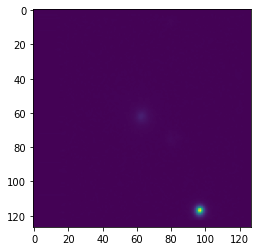

In [18]:
plt.imshow(test_hf['image'][0, 0, :, :]) # test_hf['image'][index, band, pixels, pixels]

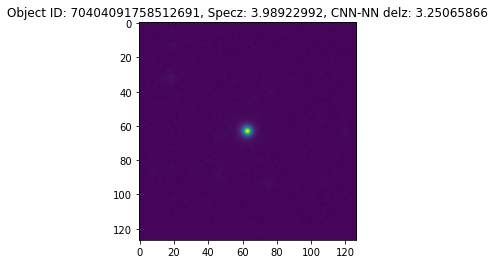

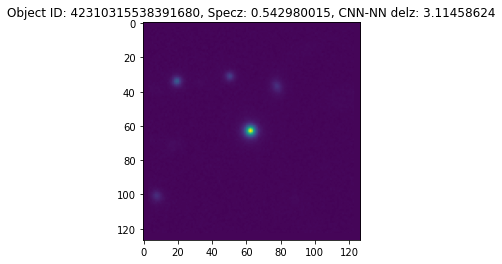

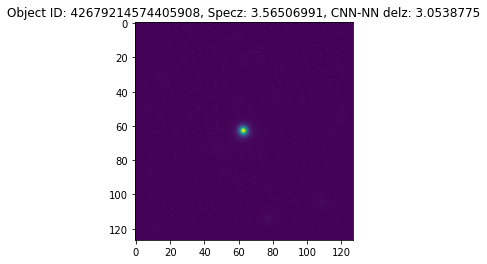

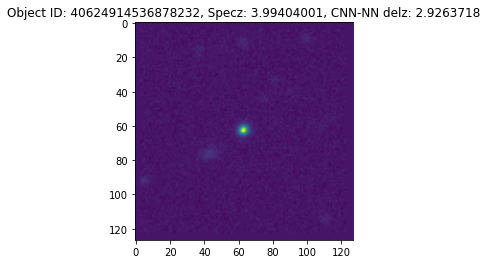

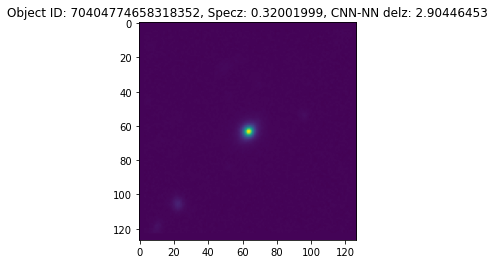

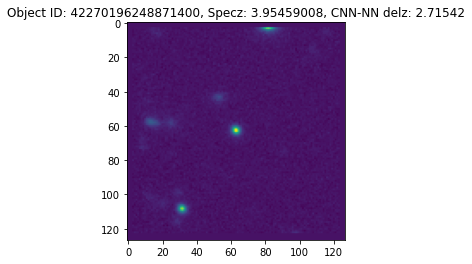

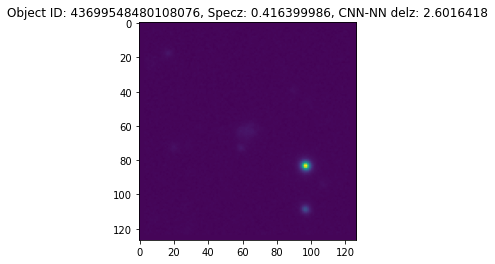

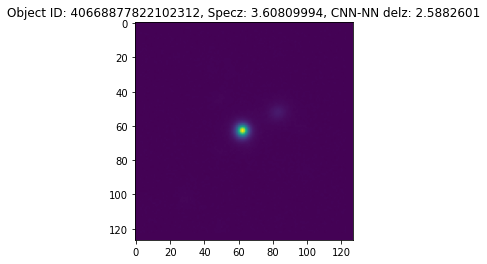

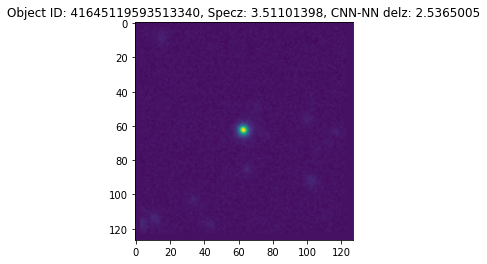

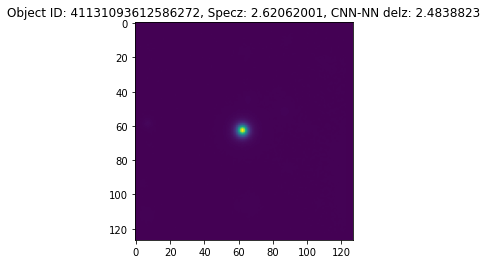

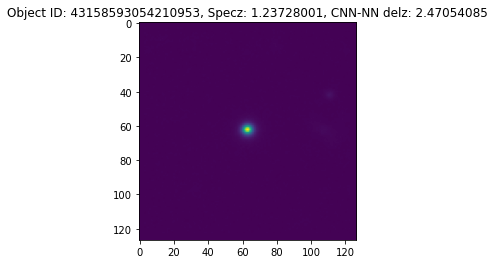

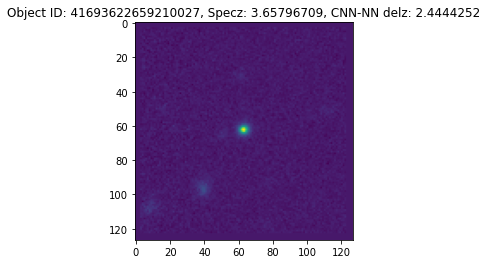

In [19]:
num_galaxies = 12 # n highest difference between the CNN and NN. This means the higher the delz the worse the images did than the mags
trunc_cnn_nn_idx = cnn_nn_oid.index[0:num_galaxies] # indecies in test_hf of the top delz's
trunc_cnn_nn_delz = cnn_nn_delz['delz'][0:num_galaxies] # top delz values 
#bands = ['g', 'r', 'i', 'z', 'y'] looking at g band for now

for current_gal, current_delz in zip(trunc_cnn_nn_idx, trunc_cnn_nn_delz): # parallel iteration
    plt.figure()
    plt.imshow(test_hf['image'][current_gal, 0, :, :])
    
    plt.title('Object ID: ' + str(test_hf['object_id'][current_gal]) + ', Specz: ' + str(test_hf['specz_redshift'][current_gal]) + ', CNN-NN delz: ' + str(current_delz))

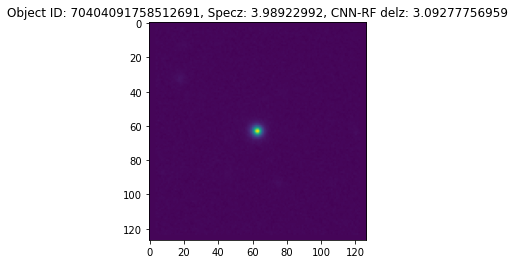

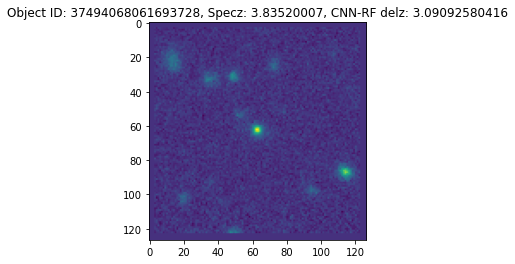

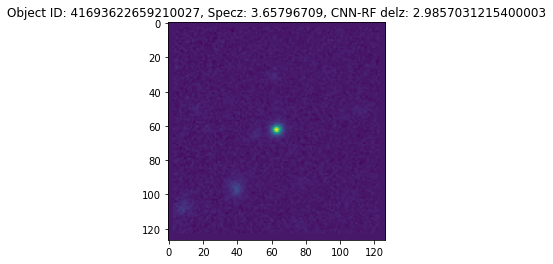

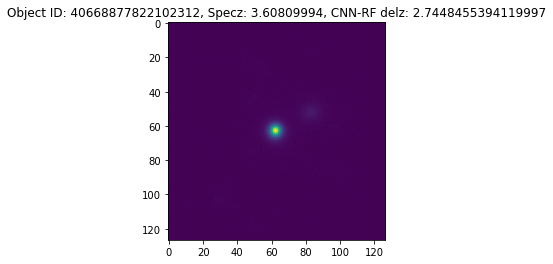

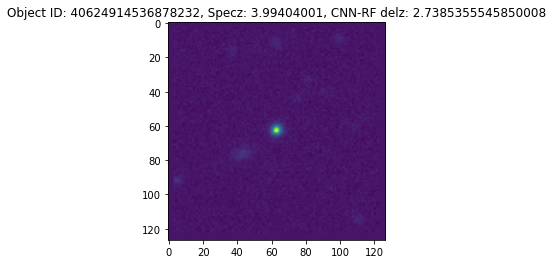

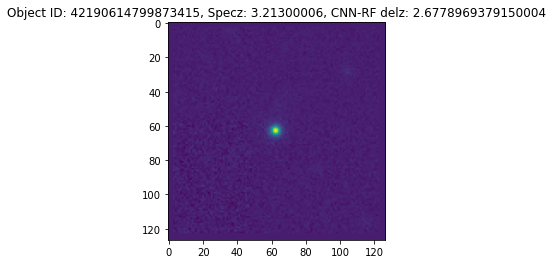

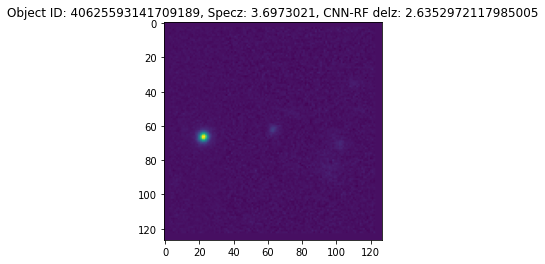

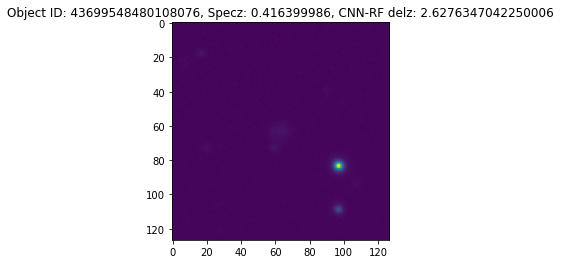

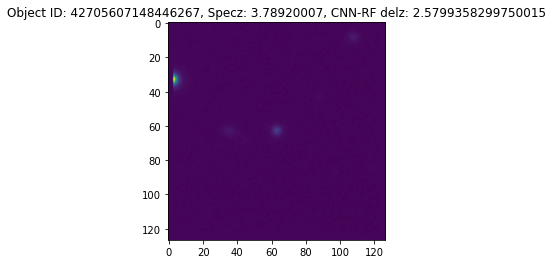

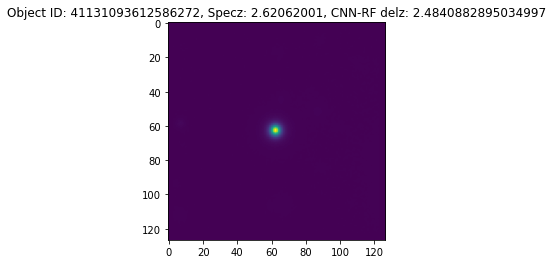

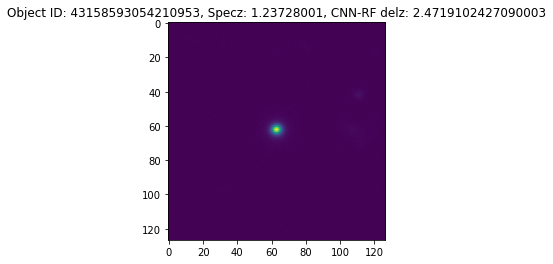

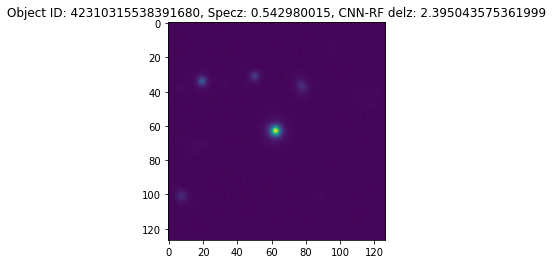

In [20]:
num_galaxies = 12 # n highest difference between the CNN and RF. This means the higher the delz the worse the images did than the mags
trunc_cnn_rf_idx = cnn_rf_oid.index[0:num_galaxies] # indecies in test_hf of the top delz's
trunc_cnn_rf_delz = cnn_rf_delz['delz'][0:num_galaxies] # top delz values 
#bands = ['g', 'r', 'i', 'z', 'y'] looking at g band for now

for current_gal, current_delz in zip(trunc_cnn_rf_idx, trunc_cnn_rf_delz): # parallel iteration
    plt.figure()
    plt.imshow(test_hf['image'][current_gal, 0, :, :])
    
    plt.title('Object ID: ' + str(test_hf['object_id'][current_gal]) + ', Specz: ' + str(test_hf['specz_redshift'][current_gal]) + ', CNN-RF delz: ' + str(current_delz))

In [29]:
cnn_nn_ids, cnn_rf_ids = test_hf['object_id'][np.sort(list(trunc_cnn_nn_idx[:]))], test_hf['object_id'][np.sort(list(trunc_cnn_rf_idx[:]))]
# arrays containing the objects id's of the top n delz's for both the CNN-NN and CNN-RF comparisons

In [30]:
list(set(cnn_nn_ids) & set(cnn_rf_ids)) # finding which galaxies occur in both comparisons. 8 matches found!

# this implies that the same galaxies are performing poorly when using images, so the images of these galaxies have something off

[41131093612586272,
 42310315538391680,
 40668877822102312,
 43158593054210953,
 41693622659210027,
 43699548480108076,
 70404091758512691,
 40624914536878232]